# TP 3:  k-Nearest Neighbor (k-NN) and linear transformations

In this TP you will implement a simple nearest Neighbors classifier using Python. 

First you will implement euclidean distance in three different ways (2 loops, 1 loop, without any loop) to see and understand the importance of the vectorization. Then you will train the kNN algorithm for a number of neighbors k, to check and comment on the model complexity. 
You will also implement the Mahalanobis distance and comment on the effect of a transformation on this distance.

The k-NN classifier consists of two stages:  
- During training, the classifier takes the training data and simply remembers it
- During testing, k-NN classifies every test sample by comparing to all training samples and transfering the labels of the k most similar training examples

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from data_utils import load_IRIS, load_CIFAR10
import matplotlib.pyplot as plt

# make figures appear inline
%matplotlib inline

# notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Firstly, we will use a dataset named CIFAR10, this dataset contains 60,000 32x32 color images in 10 different classes ([CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10)) and it will allow us to compare the three different implementations of Euclidean distance.

For windows users:
    
    * Download the dataset from [here](https://drive.switch.ch/index.php/s/heKTUcrO6waHr6e)
    * Extract the content and place the folder cifar-10-batches-py inside the folder datasets

For mac and linux users:
    * You can simply run the cell bellow (shortcut: CTRL+ENTER in the cell)

In [2]:
!datasets/get_datasets.sh

'datasets' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


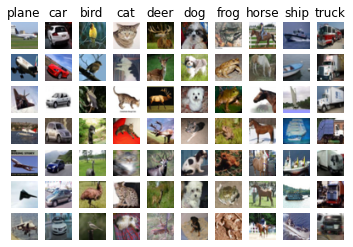

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


Now that we have the data we can focus on k-NN precisely. We will start by implementing the Euclidean distance with two loops and check that the implementation is correct before moving forward.

The k-NN algorithm can be broken down into two steps:
- The first step is to calculate the distances between each sample of the test set and those of the training set. This distances will be stored in a matrix of shape (number of test samples, number of training samples) where each element (i,j) is the distance between the i-th test and j-th train example.
- The second is to use this distance matrix to find the closest neighbors of each individual in the test set.

Let's start with implementation :  
Go to `distances.py` and implement the function `compute_euclidean_dist_two_loops`. This function uses a very inefficient double loop to compute the distance matrix one element at time.


Recall:  
The euclidean distance between two learning instances $x_i \in R^d$ and $x_j \in R^d$, where $d$ is the feature (attribute) dimention, is simply defined as:
$d_2(x_i, x_j) = \sqrt{(x_i-x_j)^T(x_i - x_j)} = \sqrt{(x_i-x_j)^2}$ 

In [7]:
# Open distances.py and implement compute_euclidean_dist_two_loops.
from distances import compute_euclidean_dist_two_loops

# Test your implementation, this should output (500,5000)
dists = compute_euclidean_dist_two_loops(X_train, X_test)
print(dists.shape)

(500, 5000)


To verify that your implementation is correct implement the prediction step.

Go to `k_nearest_neighbor.py` and implement the `predict_labels` method.

You should expect to see approximately `27%` accuracy.

In [8]:
from k_nearest_neighbor import KNearestNeighbor

# Create a k-NN classifier instance. 
# Remember that training a k-NN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
knn = KNearestNeighbor()
knn.train(X_train, y_train)

# Don't forget to implement the following method in k_nearest_neighbor.py
# We use k = 1 (which is the Nearest Neighbor).
y_test_pred = knn.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = (float(num_correct) / num_test)*100
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 27.400000


Now lets try out a larger `k`, say `k = 5`. You should expect a slightly better performance than with `k = 1`.

In [9]:
y_test_pred = knn.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = (float(num_correct) / num_test)*100
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 27.800000


If your implementation gives you the accuracy expected, well done !

Now lets improve the performance of the algorithm ! 

We ask you to implement the function `compute_euclidean_dist_one_loop` in `distances.py`.

In [10]:
# Open distances.py and implement compute_euclidean_dist_two_loops.
from distances import compute_euclidean_dist_one_loop

dists_one = compute_euclidean_dist_one_loop(X_train, X_test)

# To ensure that your new implementation is correct, the test below will compare it to the naive one using the norm.
# You should expect a value close to 0.

difference = np.linalg.norm(dists - dists_one)
print('Difference was: %f' % (difference, ))
if difference < 0.001 and np.sum(dists):
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


This implementation should improve the computational time, but we can do better!

To make the code really fast you have to avoid the use of loops. To achieve this you should vectorize the code using the matrix operations that numpy provide you.

Implement the missing part of the function `compute_euclidean_dist_no_loops` in `distances.py`.

In [11]:
# Open distances.py and implement compute_euclidean_dist_no_loops.
from distances import compute_euclidean_dist_no_loops

dists_no = compute_euclidean_dist_no_loops(X_train, X_test)

# To ensure that your new implementation is correct, the test below will compare it to the naive one using the norm.
# You should expect a value close to 0.

difference = np.linalg.norm(dists - dists_no)
print('Difference was: %f' % (difference, ))
if difference < 0.001 and np.sum(dists):
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [12]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(compute_euclidean_dist_two_loops, X_train, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(compute_euclidean_dist_one_loop, X_train, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(compute_euclidean_dist_no_loops, X_train, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 19.846889 seconds
One loop version took 66.787277 seconds
No loop version took 0.222406 seconds


## Iris dataset: model complexity and decision surfaces

Now that we have seen the effect of loops in the code, we will see how k affects the model. To simplify this part we  introduce a new dataset named [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set). This dataset has 150 samples from 3 classes, 50 from each one (Iris setosa, Iris virginica and Iris versicolor) and each sample has 4 attributes (Sepal Length, Sepal Width, Petal Length and Petal Width). 


In [28]:
# Load the Iris data.
# Cleaning up variables to prevent loading data multiple times (which may cause memory issues)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_IRIS(test=True)

# As a sanity check, we print out the size of the training and test data.
# we use all the data as training
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (100, 4)
Training labels shape:  (100,)
Test data shape:  (50, 4)
Test labels shape:  (50,)


Recall:

The mahalanobis distance is parametrized by a $d \times d$ covariance matrix $\Sigma$, in which case the metric is defined as:  

$d(x_i, x_j; \Sigma) = \sqrt{(x_i-x_j)^T\Sigma^{-1}(x_i - x_j)}$  

where we can see that the euclidean distance is simply the mahalanobis distance with the identity matrix I as covariance matrix.


Go to `distances.py` and implement the `compute_mahalanobis_dist` method.


In [40]:
# Open distances.py and implement compute_mahalanobis_dist.
from distances import compute_mahalanobis_dist, compute_euclidean_dist_one_loop, get_sigma

# euclidean distance for testing
dists = compute_euclidean_dist_one_loop(X_train, X_test)

# mahalanobis distance
dists_maha = compute_mahalanobis_dist(X_train, X_test, get_sigma(X_train, 'identity'))

# To ensure that your new implementation is correct, the test below will compare it to the naive one using the norm.
# You should expect a value close to 0.

difference = np.linalg.norm(dists - dists_maha)
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


## Model complexity
Run the kNN algorithm using the iris data set with 1, 3, 5, 10, 20, 50 neighbors. For each k use the Euclidean and the Mahalanobis distance. In the case of the Mahalanobis distance you are going to explore three different approaches to compute it. 

1. Define Σ as a diagonal matrix that has at its diagonal the average varianceof the different features, i.e. all diagonal entries $Σ_{ii}$ will be the same.
2. Define Σ as a diagonal matrix that has at its diagonal the variance of eachfeature, i.e.$σ_k$.
3. Define Σ as the full covariance matrix between all pairs of features.


Explain how the performance changes with respect to the values of k and the diffent distances that you use. How does the number of the neighbors influence the classification?

For a fixed number of neighbors (for example k= 5)  comment on the differences between the two distances and on the differences between the three different versions of the Mahalanobis distances. Comment how these affect the performance of the classification, when we should prefer the oneover the other, etc..

In [81]:
knn = KNearestNeighbor()
knn.train(X_train, y_train)


k_values = [1, 3, 5, 10, 20, 50]
n = len(X_test)
distances = ['euclidean', 'mahalanobis']
sigmas = ['diag_average_cov', 'diag_cov', 'full_cov']

for k in k_values:
    print("With k={}:".format(k))
    for dist in distances:
        if dist == 'mahalanobis':
            print("\tWith {} distance:".format(dist))
            for sig_method in sigmas:
                y_pred = knn.predict(X_test, k=k, distance=dist, sigma_method=sig_method)
                acc = (y_pred == y_test).mean()
                print("\t\tWith sigma = {} got {}/{} correct ==> accuracy: {}".format(sig_method, np.sum(y_pred==y_test), y_test.shape[0], acc))
        else:           
            y_pred = knn.predict(X_test, k=k, distance=dist, num_loops=0)
            acc = (y_pred == y_test).mean()
            print("\tWith {} distance got {}/{} correct ==> accuracy: {}".format(dist, np.sum(y_pred==y_test), y_test.shape[0], acc))

With k=1:
	With euclidean distance got 46/50 correct ==> accuracy: 0.92
	With mahalanobis distance:
		With sigma = diag_average_cov got 46/50 correct ==> accuracy: 0.92
		With sigma = diag_cov got 47/50 correct ==> accuracy: 0.94
		With sigma = full_cov got 44/50 correct ==> accuracy: 0.88
With k=3:
	With euclidean distance got 47/50 correct ==> accuracy: 0.94
	With mahalanobis distance:
		With sigma = diag_average_cov got 47/50 correct ==> accuracy: 0.94
		With sigma = diag_cov got 47/50 correct ==> accuracy: 0.94
		With sigma = full_cov got 40/50 correct ==> accuracy: 0.8
With k=5:
	With euclidean distance got 48/50 correct ==> accuracy: 0.96
	With mahalanobis distance:
		With sigma = diag_average_cov got 48/50 correct ==> accuracy: 0.96
		With sigma = diag_cov got 47/50 correct ==> accuracy: 0.94
		With sigma = full_cov got 42/50 correct ==> accuracy: 0.84
With k=10:
	With euclidean distance got 50/50 correct ==> accuracy: 1.0
	With mahalanobis distance:
		With sigma = diag_average_

*Comment this results on your report !*

## Decision surface
Visualize, study, and discuss the decision surfaces that kNN algorithm produces for the different values of k using the euclidean distance.


* To do so, you will work only in two attributes.

     * Testing will be done on an artificially generated dataset that covers in a regular manner all possible values for the two chosen attributes. To do so we need to divide the space into a grid by discretizing the space  into $n$ values between the minimum and maximum value of an attribute. Each of these values must be compared with the $n$ discrete values of the second attribute. The resulting array will be of shape ($n$ * $n$, 2)
     
     * Using your training set classify your test instances and visualize the results of the classification
     
See how the performance changes with respect to the value of k. Explain how the different values of the k change the classification boundaries in the instance space for a given training set. 



In [16]:
# Load the Iris data.
# Cleaning up variables to prevent loading data multiple times (which may cause memory issues)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train = load_IRIS(test=False)

# As a sanity check, we print out the size of the training and test data.
# we use all the data as training
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)

Clear previously loaded data.
Training data shape:  (150, 4)
Training labels shape:  (150,)


In [17]:
axes_labels = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']

# For our visualisation we will only keep the two first attributs.
# You can choose 2 attribus here
attribut_1 = 1
attribut_2 = 3

X_train_2_features = np.array([X_train[:,attribut_1], X_train[:,attribut_2]]).T
axes_label_1 = axes_labels[attribut_1]
axes_label_2 = axes_labels[attribut_2]

# and the test set will be the matrix (n*n, 2) where n is the number of values taken between
# the min and the max of each attribute
n = 150

X_test = np.zeros((n*n, 2))
tmp = np.linspace(np.min(X_train_2_features[:, 0])-0.1, np.max(X_train_2_features[:, 0])+0.1, n)
X_test[:,0] = np.repeat(tmp, n)

tmp = np.linspace(np.min(X_train_2_features[:, 1])-0.1, np.max(X_train_2_features[:, 1])+0.1, n)
X_test[:,1] = np.tile(tmp, n)


print('Training data shape: ', X_train_2_features.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (150, 2)
Testing data shape:  (22500, 2)


In [18]:
# we can now compute the distances between the training set and the test set and predict the labels

# train
knn = KNearestNeighbor()
knn.train(X_train_2_features, y_train)

# test
k_values = [1, 2, 3, 15]
y_predicted_for_each_k = np.zeros((n*n ,len(k_values)))

for i in range(len(k_values)):
    y_predicted_for_each_k[:, i] = knn.predict(X_test, k=k_values[i], distance='euclidean', num_loops=0)
            
        
print('Predicted data shape (n, number of k values): ', y_predicted_for_each_k.shape)

Predicted data shape (n, number of k values):  (22500, 4)


<ipython-input-19-2c01c87d2299>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(2,2,1+i)


<Figure size 1440x1152 with 0 Axes>

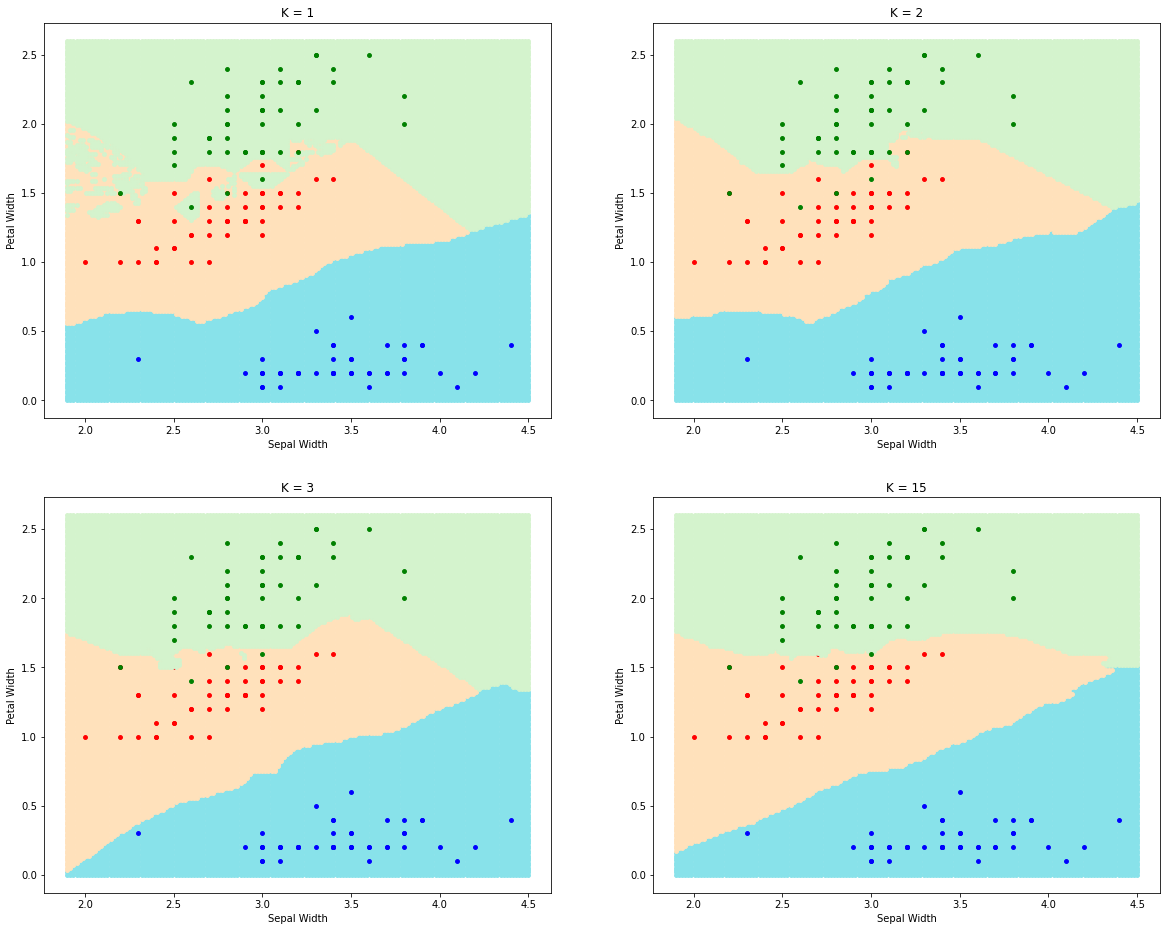

In [19]:
# plot the decision surface
colors_surfaces = ['#88E2EA', '#FFE1BB', '#D4F3CD']
colors_points = ['blue', 'red', 'green']

plt.rcParams['figure.figsize'] = (20.0, 16.0)
plt.clf()
fig = plt.figure() 

for i in range(len(k_values)):
    for n_class in range(3):
        x_train_attri_1 = X_train_2_features[y_train == n_class, 0]
        x_train_attri_2 = X_train_2_features[y_train == n_class, 1]
        
        x_test_attri_1 = X_test[y_predicted_for_each_k[:, i] == n_class, 0]
        x_test_attri_2 = X_test[y_predicted_for_each_k[:, i] == n_class, 1]
        
        ax = fig.add_subplot(2,2,1+i)  
        ax.set_title("K = "+str(k_values[i]))
        ax.scatter(x_test_attri_1, x_test_attri_2, s=15, color=colors_surfaces[n_class])
        ax.scatter(x_train_attri_1, x_train_attri_2, s=15, color=colors_points[n_class])
        ax.set_xlabel(axes_label_1)
        ax.set_ylabel(axes_label_2)

        
# each color represent a class of the problem

# don't take care of the warning

**Question**  
See how the performance change with respect to the value of k. 
Explain how the different values of the k change the classification boundaries in the instance space for a given training set. 


*Answer this question in your report*

# Linear transformations

In this exercise we are interested in the effect of a linear transformation on distances. You will need to generate points to form a unit circle and draw it. Then you have to transform your set of points with a given matrix A.
You then have to redraw the unit circle with the points obtained and comment what you see.
Finally you have to find the points such that after transformation we have the same points as those generated for the unit circle. The goal here is  to visualize that even a small transformation puts you in a new space where the distances are different.

Explain the result of each transformation that you apply.


### Unit circle
Remember that the unit cicle is given from the equation $\,  x^2 + y^2 = 1$ and in a matrix notation is written as $\, X^TX = 1$

Coding tip: you create the x variable, then y is defined from x. This means that for each x, the corresponding y value is calculated (and thus y has the same shape as x).


Shape of X : (2, 800)


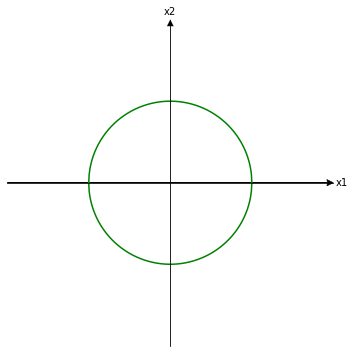

In [20]:
import numpy as np
# Open transformation.py and implement unit_circle_points and draw.
from transformation import setup_plot, draw, unit_circle_points

# get axes for the plots
fig, ax = setup_plot()

# number of points to divide the space
n = 400
# get the points of the unit circle
# the shape of X should be : (2, 2*n) = (2, 800)
X = unit_circle_points(n)

# We print out the size of X, is it equal to (2, 800) ? 
print("Shape of X :", X.shape)

# draw the unit circle
draw(ax, X, 'green')

Shape of AX : (2, 800)


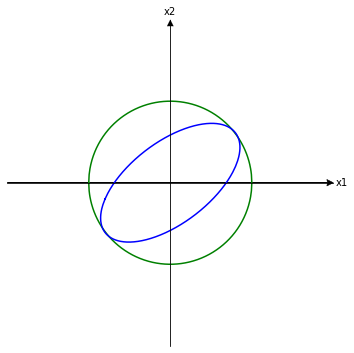

In [21]:
# Open transformation.py and implement apply_transformation_AX.
from transformation import apply_transformation_AX

fig, ax = setup_plot()

# redraw the unit circle
draw(ax, X, 'green')

# define the transformation matrix
A = np.array([[0.8, 0.3], [0.2, 0.7]])



# apply the transformation
AX = apply_transformation_AX(X, A)


# We print out the size of AX, is it equal to (2, 800) ? 
print("Shape of AX :", AX.shape)

# draw the unit circle after transformation
draw(ax, AX, 'blue')

[[0.8 0.3]
 [0.2 0.7]]
Shape of X : (2, 800)


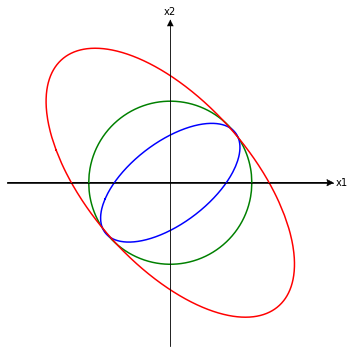

In [22]:
# Open transformation.py and implement apply_transformation_Z.
from transformation import apply_transformation_Z

fig, ax = setup_plot()

# redraw the unit circle
draw(ax, X, 'green')
# redraw the transformed circle
draw(ax, AX, 'blue')

Z = X
# apply the transformation
X = apply_transformation_Z(Z, A)

# We print out the size of Z, is it equal to (2, 800) ? 
print("Shape of X :", X.shape)

# draw the unit circle after transformation with condition
draw(ax, X, 'red')

Verify that the image you get is similar to the image to reproduce in the figures folder.

**Question **  

What is the relation between the radius of the circle and two points, let's say $x_1$ and $x_2$? (Think about distances)

*Answer this question in your report*

**Question **  

Comment on the effect of the transformations in the shape of the circle, does it change ? If yes, why does it change ?

*Answer this question in your report*

Draw the unit circles for the three covariance matrices that you consider in exercise 2 (use the same \Sigma that you have in exercise 2), i.e. draw the set of points for which $\mathbf x^T \mathbf \Sigma^{-1} \mathbf x = 1$.
If you need to compute $\mathbf A = \mathbf \Sigma^{-1/2}$ use the eigen-value decomposition of $\Sigma = \mathbf V \mathbf \Lambda \mathbf V^T$ ($\mathbf V$ has as columns the eigen-vectors of $\mathbf \Sigma$ and $\mathbf \Lambda$ is a diagonal matrix that contains the eigenvalues of $\Sigma$), and define $\mathbf A$ as $\mathbf V \sqrt{\mathbf \Lambda}$.

Code your answer in the cell bellow, use the existing functions to plot the circles.


Clear previously loaded data.
[[ 0.87750612 -0.0248    ]
 [-0.0248      0.16238367]]


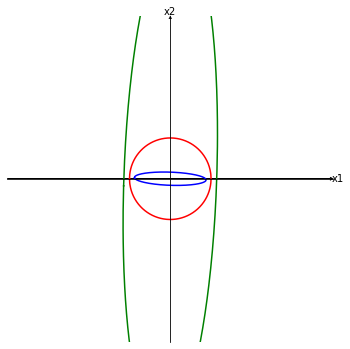

In [27]:
import numpy as np
from transformation import setup_plot, draw

fig, ax = setup_plot(4)

# -------------- CODE HERE --------------
# draw a circle, X is the set of points to draw
# draw(ax, X, 'green')

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_IRIS(test=True)


X = unit_circle_points(n)

# draw(ax, X, 'red')
# sigma = get_sigma(X_test, 'diag_average_cov')[:2,:2]
# draw(ax, apply_transformation_AX(X, sigma), 'green')
# draw(ax, apply_transformation_Z(X, sigma), 'blue')

# draw(ax, X, 'red')
# sigma = get_sigma(X_test, 'diag_cov')[:2,:2]
# draw(ax, apply_transformation_AX(X, sigma), 'blue')
# draw(ax, apply_transformation_Z(X, sigma), 'green')

draw(ax, X, 'red')
sigma = get_sigma(X_test, 'full_cov')[:2,:2]
draw(ax, apply_transformation_AX(X, sigma), 'blue')
draw(ax, apply_transformation_Z(X, sigma), 'green')

# -------------- END --------------

[[0.5 0. ]
 [0.  0.5]]
[[0.4 0. ]
 [0.  0.6]]
[[0.4 2. ]
 [2.  0.6]]


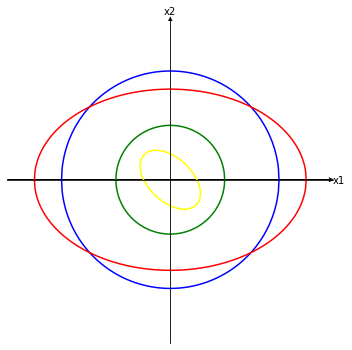

In [24]:
import numpy as np
from transformation import setup_plot, draw
fig, ax = setup_plot(3)
basic_unit_circle = unit_circle_points(n)
draw(ax, basic_unit_circle, 'green')
#---------avg-diag-sigma--------------
# avg_sigma = get_sigma(basic_unit_circle.T, 'diag_average_cov')
avg_sigma = np.array([[0.5,0],[0,0.5]]) #artificial cov
# print(avg_sigma)
avg_sigma_unit = apply_transformation_Z(basic_unit_circle,avg_sigma)
draw(ax, avg_sigma_unit, 'blue')
#------------diag-sigma--------------
# diag_sigma = get_sigma(basic_unit_circle.T, 'diag_cov')
diag_sigma = np.array([[0.4,0],[0,0.6]]) #artificial cov
# print(diag_sigma)
diag_sigma_unit = apply_transformation_Z(basic_unit_circle,diag_sigma)
draw(ax, diag_sigma_unit, 'red')
#---------full-sigma----------------
# full_sigma = get_sigma(basic_unit_circle.T, 'full_cov')
full_sigma = np.array([[0.4,2],[2,0.6]]) #artificial cov
# print(full_sigma)
full_sigma_unit = apply_transformation_Z(basic_unit_circle,full_sigma)
draw(ax, full_sigma_unit, 'yellow')